# FRQI Implementation
From the following [paper](https://link.springer.com/article/10.1007/s11128-010-0177-y)

In [196]:
from commons import *
import matplotlib.pyplot as plt
import math
import seaborn as sns
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.visualization import plot_histogram
from qiskit.circuit import qpy_serialization
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
def coord2bool(i,j,N):
    '''
    (i,j) entry in NxN matrix
    0<= i,j <= N-1
    '''
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    pad = len(get_bin(N*(N-1)+(N-1),0))
    
    return get_bin(N*i+j, pad)

def populate(counts, N):
    '''
    populate counts with states that yielded 0 shots
    '''
    for i in range(2**N):
        bnry = "{0:b}".format(i).zfill(N)
        if bnry not in counts:
            counts[bnry] = 0
    
    return counts

def my_acos(x):
    if(x>1):
        return 0
    return math.acos(x)

def counts2angles(counts):
    '''
    convert shot counts to probabilities and then to 
    angles encoding grayscale values
    '''
    
    shots = sum(counts.values())
    counts = [(k,v/shots) for k,v in counts.items() if k[-1]=='0'] 
    angles = [(k[:-1][::-1], my_acos(np.sqrt((2**(Nqs))*v))/(np.pi/2)) for k,v in counts]
    angles = sorted(angles, key=lambda x: int(x[0], 2))
    angles = np.array([v for k,v in angles]).reshape(N,N)
    
    return angles

In [520]:
# Test image: NxN BW gradient
N=4

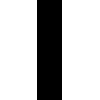

In [518]:
#gradient between 0 and 1 for N*N
#array = np.linspace(0,1,N*N)
#mat = np.reshape(array,(N,N))

#a = np.zeros(N)
#a[4], a[3] = 1, 1
#mat = 1 -  a * np.ones((N,N))

# Creates PIL image
img = Image.fromarray(np.uint8(mat * 255) , 'L')
display(img.resize((100, 100),  Image.NEAREST))

In [523]:
mat = np.array(img)/255

In [525]:
# Number of qubits required to sufficiently store the NxN pixel positions 
Nqs = math.ceil(np.log2(N*N))

# +1 qubit encoding grayscale value
qc = QuantumCircuit(Nqs+1,Nqs+1)

# We require NxN angles to encode shade of each pixel
angles = [Parameter('$t_{}$'.format(i)) for i in range(N*N)]
angles = np.array(angles).reshape(N,N)

# Apply FRQI algorithm: https://link.springer.com/article/10.1007/s11128-010-0177-y

qc.h(range(1,Nqs+1))

# Apply Rys(T_i) for the ith pixel in the NxN image 
for i in range(N):
    for j in range(N):
        #qc_t =  QuantumCircuit(1, name=str(N*i+j))
        #qc_t.ry(angles[i][j],0)
        #custom = qc_t.to_gate().control(Nqs, ctrl_state=coord2bool(i,j,N))

        
        r = RYGate(angles[i][j])
        r = r.control(Nqs, ctrl_state=coord2bool(i,j,N))
        qc.append(r,list(range(0,Nqs+1))[::-1])

angle_values = dict(zip(angles.reshape(N*N), 2*(np.pi/2)*mat.reshape(N*N)))
qc = qc.assign_parameters(angle_values)
qc.measure(np.arange(0,Nqs+1),np.arange(0,Nqs+1));

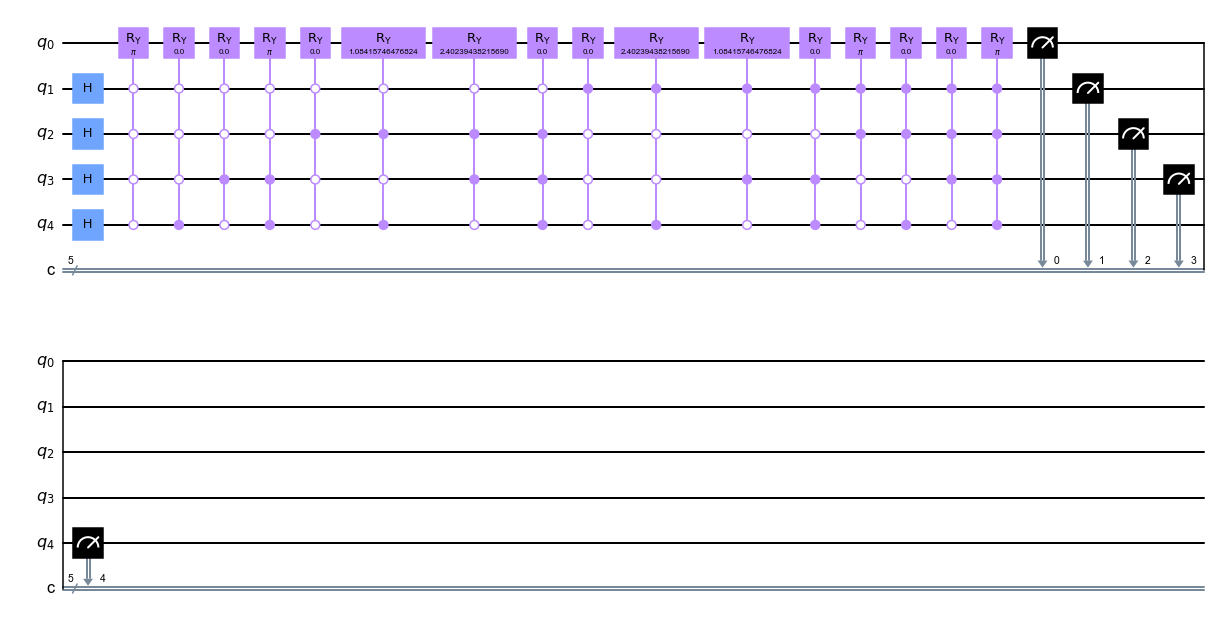

In [526]:
qc.draw('mpl')

## Shot simulator

In [511]:
shots = 1e4
backend = Aer.get_backend('qasm_simulator')
job =  execute(qc, backend, shots=shots)
counts = job.result().get_counts(qc)

In [512]:
counts = populate(counts, Nqs+1)

In [513]:
# retrieve angles and thus greyscale values from counts
angles_rec = counts2angles(counts)

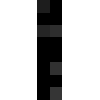

In [570]:
img_rec = Image.fromarray(np.uint8(angles_rec * 255) , 'L')
display(img_rec.resize((100, 100),  Image.NEAREST))
(img_rec.resize((100, 100),  Image.NEAREST)).save("images/stripe_rec.jpg")

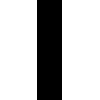

In [575]:
img = Image.fromarray(np.uint8(mat * 255) , 'L')
display(img.resize((100, 100),  Image.NEAREST))
(img.resize((100, 100),  Image.NEAREST)).save("images/stripe.jpg")

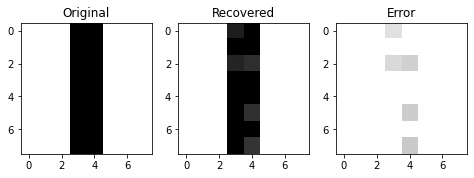

In [574]:
fig = plt.figure(figsize=(8,3))
columns = 3
rows = 1
for (i,imges,title) in zip(range(1, columns*rows +1), [img, img_rec, error], ["Original", "Recovered", "Error"]):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imges, cmap='gray', vmin=0, vmax=255)
    plt.title(title)

plt.savefig("images/comparison_stripe.jpg")
plt.show()

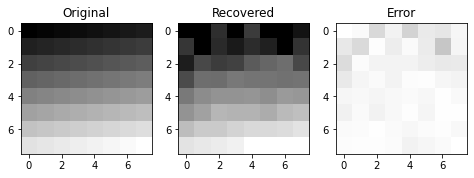

In [552]:
fig = plt.figure(figsize=(8,3))
columns = 3
rows = 1
for (i,imges,title) in zip(range(1, columns*rows +1), [img, img_rec, error], ["Original", "Recovered", "Error"]):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imges, cmap='gray', vmin=0, vmax=255)
    plt.title(title)

plt.savefig("images/comparison8x8.jpg")
plt.show()

### Noise model: Simulating Toronto

In [392]:
from qiskit.providers.aer import AerSimulator
sim_toronto = AerSimulator.from_backend(provider.get_backend("ibmq_toronto"))

In [508]:
shots = 1e5
job_sim =  execute(qc, sim_toronto, shots=shots)
counts = job_sim.result().get_counts(qc)

In [509]:
angles_rec = counts2angles(counts)

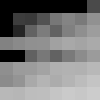

In [510]:
img_rec = Image.fromarray(np.uint8(angles_rec * 255) , 'L')
display(img_rec.resize((100, 100),  Image.NEAREST))

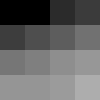

In [ ]:
img_rec = Image.fromarray(np.uint8(angles_rec * 255) , 'L')
display(img_rec.resize((100, 100),  Image.NEAREST))

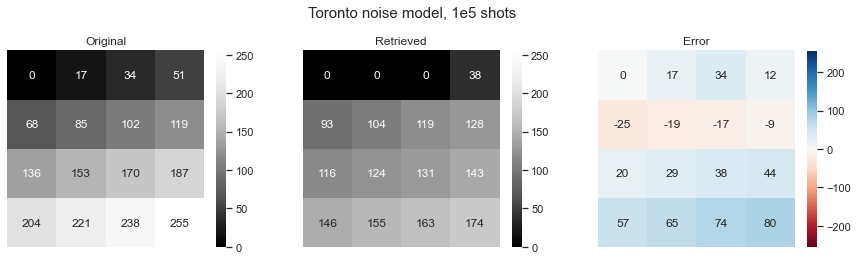

In [440]:
fig, ax =plt.subplots(1,3, figsize=(15,8))

ax_og = sns.heatmap(img, annot=True, fmt='d', cmap='Greys_r', vmin=0, vmax=255, square=True, ax=ax[0],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[0].set_title("Original")

ax_rec = sns.heatmap(img_rec, annot=True, fmt='d', cmap='Greys_r', vmin=0, vmax=255, square=True, ax=ax[1], xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[1].set_title("Retrieved")

ax_error = sns.heatmap((mat-angles_rec) * 255, annot=True, cmap='RdBu', vmin=-255, vmax=255, square=True, ax=ax[2],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[2].set_title("Error")

fig.suptitle("Toronto noise model, 1e5 shots", y=0.75, size=15)

plt.savefig("images/noise/heatmap-model4x4.jpg", bbox_inches='tight')

### Noise model: T1/T2 Relaxation

In [419]:
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

In [420]:
# From https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html
# T1 and T2 values for qubits 0-3
nqs = 5

T1s = np.random.normal(100e3, 1e3, nqs) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(5e3, 1e3, nqs)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(nqs)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(nqs):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(nqs):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])


In [422]:
backend = provider.get_backend('ibmq_toronto')

In [426]:
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = NoiseModel.from_backend(backend).basis_gates

In [492]:
job_sim = execute(qc, Aer.get_backend('qasm_simulator'),
         coupling_map=coupling_map,
         basis_gates=basis_gates,
         noise_model=noise_thermal, shots=1e5)


In [493]:
counts = job_sim.result().get_counts(qc)

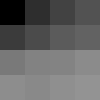

In [444]:
img_rec = Image.fromarray(np.uint8(angles_rec * 255) , 'L')
display(img_rec.resize((100, 100),  Image.NEAREST))

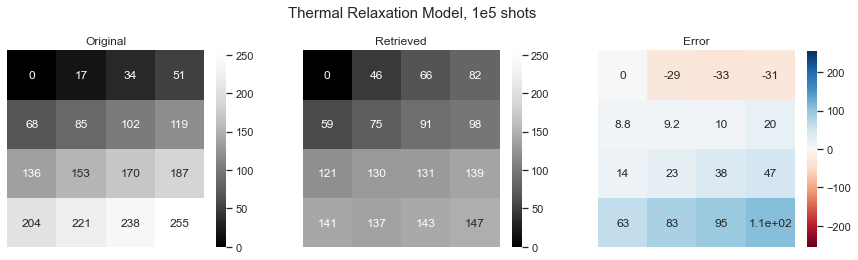

In [445]:
fig, ax =plt.subplots(1,3, figsize=(15,8))

ax_og = sns.heatmap(img, annot=True, fmt='d', cmap='Greys_r', vmin=0, vmax=255, square=True, ax=ax[0],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[0].set_title("Original")

ax_rec = sns.heatmap(img_rec, annot=True, fmt='d', cmap='Greys_r',  vmin=0, vmax=255, square=True, ax=ax[1], xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[1].set_title("Retrieved")

ax_error = sns.heatmap((mat-angles_rec) * 255, annot=True, cmap='RdBu', vmin=-255, vmax=255, square=True, ax=ax[2],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[2].set_title("Error")

fig.suptitle("Thermal Relaxation Model, 1e5 shots", y=0.75, size=15)

plt.savefig("images/noise/heatmap-thermal4x4.jpg", bbox_inches='tight')

## Real Backend

In [527]:
qc = qc.decompose().decompose()

In [528]:
with open('test.qpy', 'wb') as fd:
    qpy_serialization.dump(qc, fd)

In [529]:
with open('test.qpy', 'rb') as fd:
    new_qc = qpy_serialization.load(fd)[0]

In [530]:
QCs = [qc.copy() for i in range(100)]

In [583]:
shots = 1e5
backend = Aer.get_backend('qasm_simulator')
job_sim =  execute(QCs[0], backend, shots=shots)
counts = job_sim.result().get_counts(QCs[0])

In [164]:
job = runReal(QCs, 'ibmq_toronto')

c7gduh20jbtu2e0gfc00


In [531]:
job = runReal(QCs, 'ibmq_toronto')

c7gh3ki0jbtu2e0hio3g


In [538]:
job = provider.runtime.job("c7gh3ki0jbtu2e0hio3g")

In [575]:
counts_all = job.result(decoder=RunnerResult).get_counts()

In [576]:
counts_all = [populate(counts, 5) for counts in counts_all]

In [577]:
counts = pd.DataFrame(counts_all).sum().to_dict()

In [584]:
populate(counts, 5)
angles_rec = counts2angles(counts)

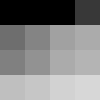

In [409]:
img_rec = Image.fromarray(np.uint8(angles_rec * 255) , 'L')
display(img_rec.resize((100, 100),  Image.NEAREST))
(img_rec.resize((100, 100),  Image.NEAREST)).save("images/grad4x4/real/img4x4_rec.jpg")

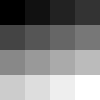

In [199]:
img = Image.fromarray(np.uint8(mat * 255) , 'L')
display(img.resize((100, 100),  Image.NEAREST))
(img.resize((100, 100),  Image.NEAREST)).save("images/grad4x4/real/img4x4.jpg")

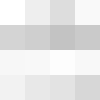

In [233]:
error = Image.fromarray(np.uint8((1-abs(mat-angles_rec)) * 255) , 'L')
display(error.resize((100, 100),  Image.NEAREST))
(error.resize((100, 100),  Image.NEAREST)).save("images/grad4x4/real/error4x4.jpg")

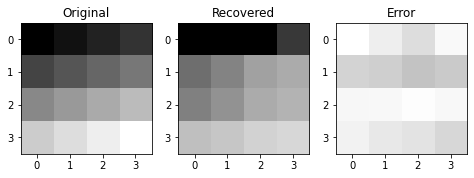

In [201]:
fig = plt.figure(figsize=(8,3))
columns = 3
rows = 1
for (i,imges,title) in zip(range(1, columns*rows +1), [img, img_rec, error], ["Original", "Recovered", "Error"]):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imges, cmap='gray', vmin=0, vmax=255)
    plt.title(title)

plt.savefig("images/grad4x4/real/comparison4x4.jpg")
plt.show()

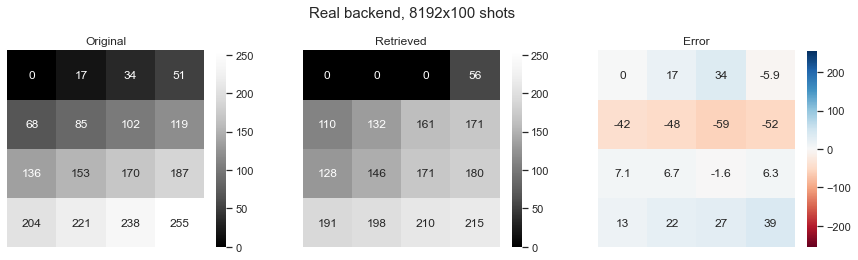

In [411]:
fig, ax =plt.subplots(1,3, figsize=(15,8))

ax_og = sns.heatmap(img, annot=True, fmt='d', cmap='Greys_r', vmin=-0, vmax=255, square=True, ax=ax[0],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[0].set_title("Original")

ax_rec = sns.heatmap(img_rec, annot=True, fmt='d', cmap='Greys_r', vmin=0, vmax=255, square=True, ax=ax[1], xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[1].set_title("Retrieved")

ax_error = sns.heatmap((mat-angles_rec) * 255, annot=True, cmap='RdBu', vmin=-255, vmax=255, square=True, ax=ax[2],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[2].set_title("Error")

fig.suptitle("Real backend, 8192x100 shots", y=0.75, size=15)

plt.savefig("images/grad4x4/real/heatmap4x4.jpg", bbox_inches='tight')

# Pattern

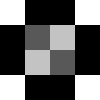

In [521]:
img = Image.open("images/src/zero.png").convert("L")
display(img.resize((100, 100),  Image.NEAREST))

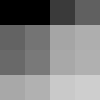

In [543]:
img_rec = Image.fromarray(np.uint8(angles_rec * 255) , 'L')
display(img_rec.resize((100, 100),  Image.NEAREST))
#(img_rec.resize((100, 100),  Image.NEAREST)).save("images/grad4x4/real/img4x4_rec.jpg")

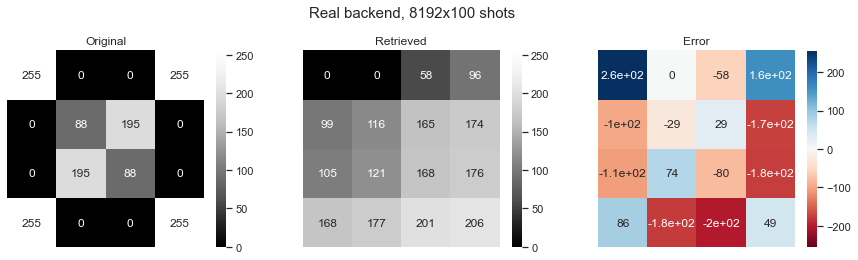

In [545]:
fig, ax =plt.subplots(1,3, figsize=(15,8))

ax_og = sns.heatmap(img, annot=True, fmt='d', cmap='Greys_r', vmin=-0, vmax=255, square=True, ax=ax[0],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[0].set_title("Original")

ax_rec = sns.heatmap(img_rec, annot=True, fmt='d', cmap='Greys_r', vmin=0, vmax=255, square=True, ax=ax[1], xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[1].set_title("Retrieved")

ax_error = sns.heatmap((mat-angles_rec) * 255, annot=True, cmap='RdBu', vmin=-255, vmax=255, square=True, ax=ax[2],  xticklabels=False, yticklabels=False, cbar_kws={"shrink": .45})
ax[2].set_title("Error")

fig.suptitle("Real backend, 8192x100 shots", y=0.75, size=15)

plt.savefig("images/pattern/heatmap.jpg", bbox_inches='tight')

In [585]:
counts = {k[:-1][::-1]:v for k,v in counts.items() if k[-1]=='0'}

In [581]:
counts_filter = {k[:-1][::-1]:v for k,v in counts.items() if k[-1]=='0'}

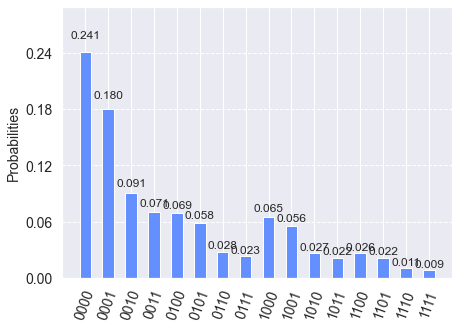

In [582]:
# Real
plot_histogram(counts_filter)

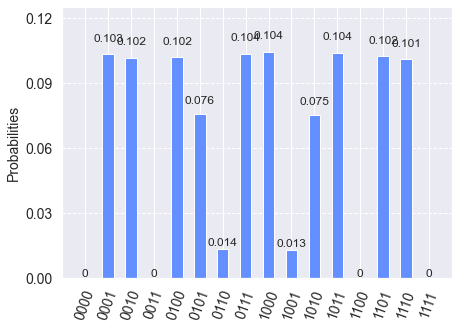

In [586]:
# Simulation
plot_histogram(counts)